# Using Pydemic

## Introduction

This is a notebook-tutorial explaining the main concepts and functionalities in Pydemic. It can also be a nice introduction to basic epidemiological concepts if you know more Python than epidemiology ;-)

When running on the notebook, it is convenient to import all functions in the `pydemic` package. You probably should try to organize your code better and avoid star imports when doing more serious work, but for now, or when you need it for just a quick and dirt job, importing everything from `pydemic.all` should be good enough.

In [1]:
from pydemic.all import *

## The SIR Model

The classic SIR model splits the population into 3 compartments of Susceptible, Infectious and Recovered individuals. Susceptibles are the individuals in a population that can be contaminated by a disease. In the case of COVID-19, we can assume that the whole population minus the infectious seed is susceptible. 

There are great resources that explain the SIR model online, and if you are not familiar with it, I recommend watching the youtube video bellow or checking the very nice [Wikipedia Page](https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology).

In [2]:
youtube(url='https://www.youtube.com/watch?v=k6nLfCbAzgo&t=496s')

NotImplemented

### Using the SIR model

Pydemic implements a SIR class in the `pydemic.models` package. Using it is very simple: import the class and create an instance, possibly tweaking some parameters. The default set of parameters is good to simulate COVID-19 in the early stages of infection, when the population both susceptible and not prepared for a pandemic emergency.

In [3]:
from pydemic.models import SIR

m = SIR()

Now that we have created a model instance, let us execute the simulation. By default, Pydemic measure time in days and uses dates in most plots and dataframes. It is generally more convenient to use dates in order to confront the model with real data and to use a numeric time unit in order to do modelling. Either way, it is easy to convert between both representations. 

Let us make the simulation run for 120 days and plot the results.

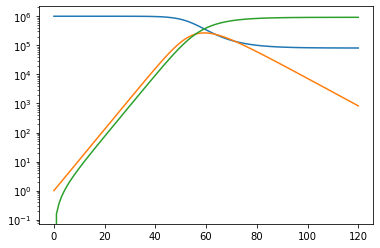

In [4]:
m.run(120)
m.plot()

The basic reproduction number, or R0, tells how many new infections on average an infected individual produces in a totally susceptible population. It is a critical parameter to understand the progression of an epidemic. Social isolation, quarentines, and whatnot are attempts to reduce this number and thus control the spread of the disease. When using simple models such as SIR, all of those measures must be translated into changes of R0. 

It is estimated that rigorous hand-washing can reduce transmissibility of a respiratory disease such as COVID-19 or Influenza by as much as 20%. Let us be optimistic that everyone will follow this recomendation very strictly. In this scenario, R0 should be reduced by this same ammount. 

When creating a new model instance, we can give it a name, set parameters and even ask it to run the simulation for some time. The syntax is shown bellow. Lets see what happens!

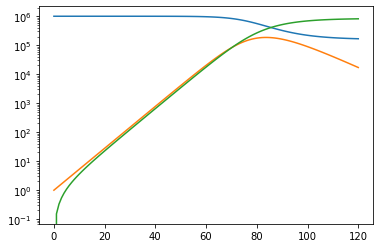

In [5]:
m2 = SIR(R0=m.R0 * 0.8, run=120, name='SIR (hand washing)')
m2.plot()

It seems to be a little better than the previous run, but it is hard to compare both when they are displayed in different plots. We can easily extract time series from each model by selecting the desired component by name, as if querying keys in a dictionary. Lets load the "I" component of each model and construct a dataframe for comparison.

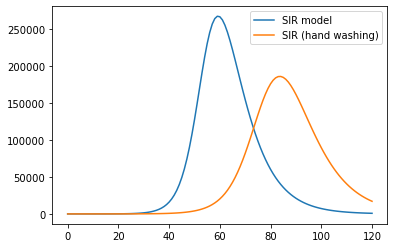

In [6]:
df = pd.DataFrame({m: m["I"], m2: m2["I"]})
df.plot()

Not bad!

We can extract many different data this way, and not only the susceptible, infectious and recovered components of the SIR model. Pydemic models also accept a clever syntax that makes it easy to produce simple transformations into the extracted
components simply by using a trick when naming the components. 

For instance, we might want to know the attack rate, i.e., the percentage of folks who got infected or are currently infectious in percentages. Of course we could load the time series, divide it by population size and multiply by 100 to get the percentage values. It is much easier, however, to use the 'ppc' (population percentage) transformation to acomplish the same task. 

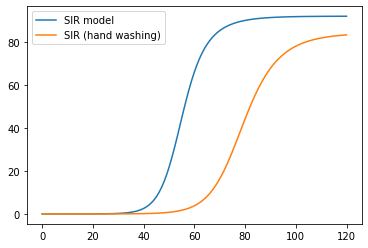

In [7]:
df = pd.DataFrame({m: m["R:ppc"] + m["I:ppc"], m2: m2["R:ppc"] + m2["I:ppc"]})
df.plot()

Now we can see that, with rigorous hand washing, the spread is delayed and a slightly smaller fraction of the population gets affected. This is good, but with the available information, we still have no clue if it is good enough.

# Hospitalization model

The R in the SIR model stands for "Recovered" or "Removed". The first term is slightly misleading since it implies that after some infectious period, everyone becomes cured. This is not necessarely what happens: the SIR model does not say anything about the clinical development of infected individuals. They may end up cured and immune or dead and the model is indifferent to that.

Obviouslly, we are generally very much interested on distinguishing those two different outcomes. A simple approach would be to take the "R" and use the disease *infection fatality rate* (IFR) to estimate which fraction of this compartment would have a deadly outcome. 

It would be something like that: 

In [8]:
IFR = 0.006  # According to Verity, et. al.
deaths = pd.DataFrame({m: m["R"] * IFR, m2: m2["R"] * IFR})

# Let us see the final outcome
deaths.iloc[-1]

SIR model             5510.601359
SIR (hand washing)    4893.735896
Name: 120.0, dtype: float64

This simple calculation fails to consider many complications that arise in the interaction between the fatality rate and the capacity of healthcare systems to handle an epidemic. The somewhat optimist figure of 0.6% IFR assumes that hospitals are not overwhealmed and can still provide a decent treatment to all income patients. 

When the capacity overflows, there is a dangerous potential for a dramatic increase in fatality rates. Rather then trying to guess what would be the IRF in different scenarios, we can use models to compute just that from the resulting simulation data. Another important issue is timing: hospitalized cases often take longer to resolve and we should see a greater lag between the infectious and recovered rather than simply taking a fixed fraction of "R" as a measurement of the number of deaths.  

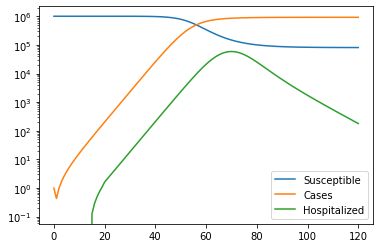

In [9]:
h = m.clinical.hospitalization_with_delay()
h.plot(["susceptible", "cases", "hospitalized"])
plt.legend()

The `.clinical` attribute of an infectious model exposes a namespace with several different models for clinical evolution of the disease. The default model simply computes a crude estimate using the IFR and can be acessed using either `m.clinical.crude()` or as the default clinical model by calling `m.clinical()` or passing an explicit IFR as in `m.clinical(IFR=0.02)`.

The clinical models objects share a lot of functionality with regular infectious models. We can use the same syntax to extract components, to inspect and change parameters and they share many methods with the underlying infectious model. They even expose the components of the infectious model, when requested, so we can do something like this 

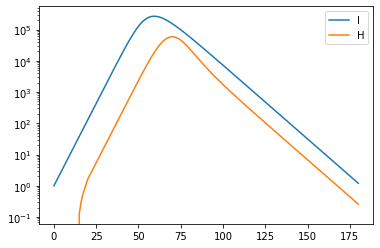

In [11]:
h.run(30)  # run more 30 days both in the infectious and the clinical models
h[["I", "H"]].plot(logy=True)

# The real world 😨

The next step is to leave the cozy confines of our abstract mathematical models and confront it with real world data. There are many ways the real world can spoil our models: hospital capacities vary widely between regions, IFR are strongly demography dependent and demography also varies widely between countries. Most importantly, each region is responding very differently and might be in a different epidemiological moment and should also exhibit very different values of R0.

We start exploring the "covid" object, which exposes the main known parameters of the disease as functions. We explicitly exposed all information as functions (rather than attributes) because basically all relevant aspects of the epidemic are uncertain and estimates can vary widely depending on location, assumptions, statistical models, etc. 

## Covid parameters, demography and regional data

Since Pydemic was created to model COVID-19, this is the only implemented disease for now. In the future we plan to add other important diseases such as Influenza, Dengue, Zika, etc. Unfortunately, COVID-19 is not the only thing we sould worry about in this world...

From a programming perspective, the "disease" objects are stored in the `pydemic.diseases` module. Let us import covid from there and investigate what does it show to us.

In [12]:
from pydemic.diseases import covid

covid

<module 'pydemic.diseases.covid' from '/home/chips/.local/lib/python3.8/site-packages/pydemic/diseases/covid.py'>

The covid object exposes a mortality tables and functions to work with this information.

In [13]:
covid.mortality_table()

AttributeError: module 'pydemic.diseases.covid' has no attribute 'mortality_table'

It shows the *case fatality rate* (CFR) and *infection fatality rate* (IFR). The difference between both is that IFR considers **all** infections, even those that were not diagnosed or did not even exhibit symptoms. We can confront this mortality table with a country demography and compute the effective CFR or IFR for that location.

It seems a lot of data to gather, but fortunately, Pydemic integrates well with the `mundi` package to have access to a lot of useful information about most countries in the world and even some of its sub-divisions. Let us load demography data for some countries and see how does it work.

In [ ]:
from pydemic import data

it = data.demography("Italy")  # We could (and perhaps should) use iso codes, "IT" and "CN"
cn = data.demography("China")
br = data.demography("Brazil")

It is easy to see that each country have very different age structures

In [ ]:
df = pd.DataFrame({"italy": it, "china": cn, "brazil": br})
df.plot.barh()

Now we can use this data to adjust the IFR and CFR for each country. We should expect that Italy, being the country with a larger fraction of old people, should suffer the most. This is also what the numbers show us. 

In [ ]:
for country in [it, cn, br]:
    IFR = covid.IFR(demography=country)
    print(f'{country.name}: {pc(IFR)}')

## Fitting epidemic curves

Ok, that is good, but how about the epidemic curves? Can we fit it to our data? Is the model corresponding to reality?

We must first gather data and then load into our models. Pydemic models expect data in the form of a dataframe with dates or days in the index and a "cases" and "deaths" columns. It will try to adjust the basic model parameters with respect with those two curves.

Let us start by downloading the data using `covid.fetch_data()` function.

In [ ]:
epidemic_curves = covid.fetch_data([it.name, cn.name, br.name])
epidemic_curves.plot()

Now that we have the incidence data, let us use it to calibrate the models. We must initialize 
the models with population statistics and calibrate the IFR for each country.

In [ ]:
data = epidemic_curves["CN"]
m_china = SIR(demography=cn, empirical_data=data)
m_china.run(len(data))

In [ ]:
data = epidemic_curves["CN"]
m_china = SIR(demography=cn, empirical_data=data)
m_china.run(60)

This

In [ ]:
m_china.params